In [1]:
import os
import glob
import sys
import json
import time
import copy
import torch
import click
import pickle
import numpy as np
import logging as log
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import torch, torch.nn as nn
import segmentation_models_pytorch as sm
import scipy.stats as sps
import math
from scipy.stats import bartlett
from scipy import stats

from tqdm import tqdm
from pathlib import Path
from skimage.io import imread
from torch.autograd import Variable
from losses_pytorch.segmentation.twodim.entropy_based_losses import cross_entropy_with_logits_loss

from precode.models import UnetSm
from precode.scoring import jaccard_score
from precode.labels.wheat_segmentation import WHEAT_LABELS
from precode.net_utils import init_determenistic, batch_ids_generator

import queue

from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert


In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
img_path_2 = '/home/jupyter-fly_cv/Igor/Plants/data/Новый признак'
img_path = '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды'
model_checker_path = '/home/jupyter-fly_cv/Igor/Plants/10-27:11-02-21_model_wheat_segmentation_checker_cpu.bin'

In [3]:
infer_aug = A.Compose([ 
                        A.Resize ( height=512,
                                   width=512,
                                   interpolation=1,
                                   always_apply=False,
                                   p=1. ),
                        A.Normalize ( mean=(0.485, 0.456, 0.406),
                                      std=(0.229, 0.224, 0.225),
                                      max_pixel_value=255.0,
                                      always_apply=False,
                                      p=1.0 )
                      ])

def inverse_infer_aug(height, width):
    return A.Compose([
                       A.Resize ( height=height,
                                  width=width,
                                  interpolation=cv2.INTER_NEAREST,
                                  always_apply=False,
                                  p=1. ) 
                    ])

In [4]:
def create_model(model_file):
    model = UnetSm( out_channels=2,
                    encoder_name='efficientnet-b0' )
 
    with open(model_file, 'rb') as f:
        state = pickle.load(f)

    model.load_state_dict(state)
    model.cuda()

    return model

In [5]:
def augmented_load2(img, aug):
    auged = aug(image=img)
    aug_img = auged['image']

    aug_img = aug_img.transpose(2, 0, 1)

    return np.array([aug_img])

def infer(model, img):
    model.eval()

    with torch.no_grad():
        imgs_batch_ = augmented_load2(img, infer_aug)
        imgs_batch = torch.cuda.FloatTensor(imgs_batch_)

        logits_batch = model(imgs_batch)

        pred_masks_batch = logits_batch.argmax(dim=1)
        pred_mask = pred_masks_batch.cpu().data.numpy()[0]

        original_size = img.shape[:2]

        original_pred_mask = inverse_infer_aug(*original_size)(image=pred_mask)['image']
        original_pred_mask = original_pred_mask.astype('uint8') * 255 

    return original_pred_mask

In [6]:
def filename_pref_png(name, pref):
    names = name.split('/')
    png_names = names[-1].split('.')
    names[-1] = png_names[0] + '.' + 'png'
    names[-1] = pref + names[-1]
    new_name = ''
    for n in names:
        if n != names[-1]:
            new_name =new_name + n + '/'
        else:
            new_name =new_name + n
    return new_name    

In [7]:
def all_jpg_img(path):
    img_names = []

    for dirname, _, filenames in os.walk(path):
        for filename in filenames: 
            name = os.path.join(filename)
            if name.split('.')[-1] != 'jpg':
                continue
            img_names.append(dirname + '/' + name)
            
    return img_names

In [8]:
def max_contours(contours):
    
    if len(contours) == 0:
        return np.array([[0,0],[0,1],[1,0]])

    max_cnt = contours[0] 
    max_area_cnt = -1
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area_cnt:
            max_area_cnt = area
            max_cnt = cnt
            
    return max_cnt

In [9]:
def rectangle(mask):
    new_mask = np.where(mask > 0, 1,0)
    non_zero_mask = np.nonzero(new_mask)
    h = non_zero_mask[0].max() - non_zero_mask[0].min()
    w = non_zero_mask[1].max() - non_zero_mask[1].min()
    x = set(non_zero_mask[1])
    y = set(non_zero_mask[0])
    x = sum(x)/len(x)
    y = sum(y)/len(y)
    return w,h,x,y

In [10]:
def plant_rectangle(mask,extra_w = 0,extra_h = 0):
    
    w,h,x,y = rectangle(mask)
    #y = img.shape[0] -y
    stripe = np.zeros((mask.shape[0],mask.shape[1])).astype(np.uint8)
    w *=(1 + extra_w) 
    h *=(1 + extra_h) 
    w_2 = int(w/2)
    h_2 = int(h/2)
    x = int(x)
    
    points = np.array([(int(x + w_2),int(y + h_2)),(int(x - w_2),int(y + h_2)),(int(x - w_2),int(y - h_2)),(int(x + w_2),int(y - h_2))])
    cv2.fillPoly(stripe,[points],1)   
        
    stripe = np.where(stripe > 0, 1,0)
    stripe = stripe.astype(np.uint8)
    
    return stripe

In [11]:
def color_checker_stripe(img,model_checker_path):
    img_checker = infer(create_model(model_checker_path),img)
    img_checker = cv2.GaussianBlur(img_checker, (21, 21), 0)
   # img_checker = np.round(img_checker/255)
   
    img_checker = cv2.threshold(img_checker,15,255,cv2.THRESH_BINARY)[1] 
    
    contours, hierarchy = cv2.findContours(img_checker,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_checker = np.zeros((img.shape[0],img.shape[1])).astype(np.uint8)
    cv2.fillPoly(img_checker,[max_contours(contours)],1)

    checker_stripe = np.zeros((img.shape[0],img.shape[1])).astype(np.uint8)
    w,h,x,y = rectangle(img_checker)
    w_2 = int(w/2) +1
    h_2 = int(h/2) + 1
    x = int(x)
    y = int(y)
    
    im_h = img.shape[0]
    
    points = np.array([(int(x + w_2),int(im_h)),(int(0),int(im_h)),(int(0),int(y - h_2)),(int(x + w_2),int(y - h_2))])
    cv2.fillPoly(checker_stripe,[points],1)   
    
    return 1 - checker_stripe

In [12]:
def plant_stripe(mask,extra_w = 0):
    
    w,h,x,y = rectangle(mask)
    stripe = mask.copy()
    w *=(1 + extra_w) 
    w_2 = int(w/2)
    x = int(x) - 1
    
    for i in range(int(w) +100):
        if x-w_2+i >= 0 and  x-w_2+i < mask.shape[1]:
            stripe[:,x-w_2+i] = np.zeros(stripe.shape[0]).astype(np.uint8) + 255
        
    stripe = np.where(stripe > 0, 1,0)
    stripe = stripe.astype(np.uint8)
    
    return stripe

In [13]:
def pot_segment(img,mask):
    
    img_checker = color_checker_stripe(img,model_checker_path).astype(np.uint8)
    stripe = plant_stripe(mask,extra_w = 0.0)
    bl_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    
    new_img = stripe * bl_img*img_checker
    plant_mask = np.where(mask > 0, 0,1).astype(np.uint8)
    new_img *= plant_mask
    new_img = cv2.threshold(new_img,27,255,cv2.THRESH_BINARY)[1]
    
    contours, hierarchy = cv2.findContours(new_img,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    pot = np.zeros((img.shape[0],img.shape[1])).astype(np.uint8)
    cv2.fillPoly(pot,[max_contours(contours)],1)
    
    w,h,x,y = rectangle(pot)
    pot = np.zeros((img.shape[0],img.shape[1])).astype(np.uint8)
    w = w #* 1.1
    w_2 = int(w/2) +1
    h_2 = int(h/2) + 1
    points = np.array([(int(img.shape[1] - 1),int(y + h_2)),(int(0),int(y + h_2)),(int(0),int(y - h_2)),(int(img.shape[1] - 1),int(y - h_2))])
    cv2.fillPoly(pot,[points],1)

    pot = np.where(pot == 1, 1,0).astype(np.uint8)
    
    return pot

In [14]:
def final_mask_lenght(mask,img):
    new_mask = mask.copy()
    
#     pot = pot_segment(img,mask)
#     new_mask = new_mask * (1-pot)
    
    new_mask = cv2.GaussianBlur(new_mask, (21, 21), 0)
    new_mask = cv2.threshold(new_mask,15,255,cv2.THRESH_BINARY)[1]
    
    contours, hierarchy = cv2.findContours(new_mask,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cont_mask = np.zeros((new_mask.shape[0],new_mask.shape[1])).astype(np.uint8)
    cv2.fillPoly(cont_mask,[max_contours(contours)],1)
    
    sk_mask = new_mask * cont_mask
    sk_mask = cv2.threshold(sk_mask,15,1,cv2.THRESH_BINARY)[1]
    sk_mask = skeletonize(sk_mask)
    
    return sk_mask

In [15]:
def final_mask_2(mask,img):
    new_mask = mask.copy()
    
#     pot = pot_segment(img,mask)
#     new_mask = new_mask * (1-pot)
    
#     new_mask = cv2.GaussianBlur(new_mask, (21, 21), 0)
#     new_mask = cv2.threshold(new_mask,15,255,cv2.THRESH_BINARY)[1]
    
    new_mask = cv2.threshold(new_mask,15,1,cv2.THRESH_BINARY)[1]
    new_mask = skeletonize(new_mask)
    
    return new_mask

In [16]:
def bio_mass(mask):
    mask_b = np.where(mask > 0, 1, 0)
    count = np.sum(mask_b)
    return count 

In [17]:
def read_mask(path,global_path):
    if global_path == img_path_with_corr:
        names = path.split('/')
        new_name = ''
        for name in names:
            if name == 'color_correction_01.02.22':
                name = 'Гаплоиды'
            if name != names[-1]:
                new_name += name + '/'
            else:
                new_name += name
        return mask_name(new_name)
    
    if global_path == img_path:
        return mask_name(path)

In [18]:
def direct_name(path):
    names = path.split('/')
    direct_path = ''
    for p in names:
        if p == names[-1]:
            break
        direct_path += p + '/'
    return direct_path

In [19]:
def sample_name(path):
    names = path.split('/')
    names = names[-1].split('.')
    return names[0] 

In [20]:
def mask_name(path):
    dir_name = direct_name(path)
    s_name = sample_name(path)
    return dir_name + filename_pref_png(s_name, 'mask_')

In [21]:
def istok(mask):
    n_z = np.nonzero(mask)
    m = max(n_z[0])
    n_z = np.nonzero(mask[m,:])
    ist = list()
    for v in n_z[0]:
        ist.append((m,v))
    return ist

def neighbors(mask,v):
    a = list()

    if v[0] - 1 >= 0:
        if mask[v[0] - 1, v[1]] == 1:
            a.append((v[0] - 1, v[1]))
        if v[1] + 1 < mask.shape[1] and mask[v[0] - 1, v[1] + 1] == 1:
            a.append((v[0] - 1, v[1] + 1))
        if v[1] - 1 >= 0 and mask[v[0] - 1, v[1] - 1] == 1:
            a.append((v[0] - 1, v[1] - 1))

    if v[1] + 1 < mask.shape[1] and mask[v[0], v[1] + 1] == 1:
        a.append((v[0], v[1] + 1))
    if v[1] - 1 >= 0 and mask[v[0], v[1] - 1] == 1:
        a.append((v[0], v[1] - 1))

    if v[0] + 1 < mask.shape[0]:
        if v[1] + 1 < mask.shape[1] and mask[v[0] + 1, v[1] + 1] == 1:
            a.append((v[0] + 1, v[1] + 1))
        if v[1] - 1 >= 0 and mask[v[0] + 1, v[1] - 1] == 1:
            a.append((v[0] + 1, v[1] - 1))
        if mask[v[0] + 1, v[1]] == 1:
            a.append((v[0] + 1, v[1]))

    return a

In [22]:
def dfs_no_recurs(v,color,mask,black_edjes):
    pred = -1
    pra_pred = -1
    stack = list()
    stack.append((v,pred,pra_pred))
    while(len(stack) != 0):
        v,pred,pra_pred = stack.pop()
        if color[v[0],v[1]] == 1:
            continue
        color[v[0],v[1]] = 1
        neigh = neighbors(mask,v)
        neigh.reverse()
        for n in neigh:
            if pred != -1 and n == pred:
                continue
            if pra_pred != 1 and pra_pred == n:
                continue
            if set([(v,n)]).issubset(set(black_edjes)):
                continue

            if color[n[0],n[1]] == 1 and v[0] < n[0]:
                black_edjes.append((v,n))
                black_edjes.append((n,v))
      #         mask[v[0], v[1]] = 0
            else:
                stack.append((n,v,pred))

        color[v[0],v[1]] = 1

def dfs_no_recurs_all(v,color,mask,black_edjes):
    pred = -1
    pra_pred = -1
    stack = list()
    stack.append((v,pred,pra_pred))
    while(len(stack) != 0):
        v,pred,pra_pred = stack.pop()
        if color[v[0],v[1]] == 1:
            continue
        color[v[0],v[1]] = 1
        neigh = neighbors(mask,v)
        neigh.reverse()
        for n in neigh:
            if pred != -1 and n == pred:
                continue
            if set([(v,n)]).issubset(set(black_edjes)):
                continue

            if color[n[0],n[1]] == 1 and v[0] < n[0]:
                black_edjes.append((v,n))
                black_edjes.append((n,v))
      #         mask[v[0], v[1]] = 0
            else:
                stack.append((n,v,pred))

        color[v[0],v[1]] = 1


In [23]:
def One_Connect_area(v,color,mask,black_edjes):
    pred = -1
    pra_pred = -1
    stack = list()
    stack.append((v,pred,pra_pred))
    while(len(stack) != 0):
        v,pred,pra_pred = stack.pop()
        if color[v[0],v[1]] == 1:
            continue
        color[v[0],v[1]] = 1
        neigh = neighbors(mask,v)
        neigh.reverse()
        for n in neigh:
            if pred != -1 and n == pred:
                continue
            if pra_pred != 1 and pra_pred == n:
                continue
            if set([(v,n)]).issubset(set(black_edjes)):
                continue

            if color[n[0],n[1]] == 1:
                black_edjes.append((v,n))
                black_edjes.append((n,v))
      #         mask[v[0], v[1]] = 0
            else:
                stack.append((n,v,pred))

        color[v[0],v[1]] = 1

def Connect_area(mask,black_edjes):
    new_mask = mask.copy()
    n_z = np.nonzero(new_mask)
    color = np.zeros((new_mask.shape[0], new_mask.shape[1]))
    v = []
    n_z_0 = n_z[0]
    while True:
        new_mask = new_mask - color
        n_z_0 = np.nonzero(new_mask)[0]
        color = np.zeros((new_mask.shape[0], new_mask.shape[1]))
        if n_z_0.shape[0] == 0:
            break
        m1 = max(n_z_0)
        m2 = np.nonzero(new_mask[m1, :])[0]
        One_Connect_area((m1, min(m2)), color, new_mask, black_edjes)
        n_z_col_0 = np.nonzero(color)[0]
        if n_z_col_0.shape[0] > 5:
            m1 = max(n_z_col_0)
            m2 =np.nonzero(color[m1, :])[0]
            v.append((m1,m2))

    return v

In [24]:
def leaf_dfs(mask,black_edjes):
    c_a = Connect_area(mask,[])
    le = []
    color = np.zeros((mask.shape[0], mask.shape[1]))
    stack = list()
    comb = 0
    err_comb = 0
    for layer in c_a:
        l_0 = layer[0]
        for l_1 in layer[1]:
            pred = (-1,-1)
            pra_pred = (-1,-1)
            #le.append((l_0,l_1))
            stack.append(((l_0,l_1),pred,pra_pred,0,0))
            le.append(((l_0,l_1), layer))
        while(len(stack) != 0):
            v,pred,pra_pred,comb,err_comb = stack.pop()
            if color[v[0],v[1]] == 1:
                continue
            color[v[0],v[1]] = 1
            neigh = neighbors(mask,v)
            neigh.reverse()
            if pra_pred[1] <= 3 and pred[1] <= 3:
                comb += 1
            else:
                comb = 0
#                 if pra_pred[1] == 4:
#                     if err_comb > 2:
#                         comb = 0
#                         err_comb = 0
#                     else:
#                         err_comb += 1
            if pra_pred[1] <= 3 and pred[1] <= 3 and len(neigh) <= 1 and pred[1] != -1 and pra_pred[1] != -1:
                if comb > 11:
                    le.append((v,layer))
            for n in neigh:
                if pred[0] != -1 and n == pred[0]:
                    continue
                if set([(v,n)]).issubset(set(black_edjes)):
                    continue

                if color[n[0],n[1]] == 1:
                    black_edjes.append((v,n))
                    black_edjes.append((n,v))
      #         mask[v[0], v[1]] = 0
                else:
                    stack.append((n,(v,len(neigh)),pred,comb,err_comb))

            color[v[0],v[1]] = 1

    leaf = list()
    b= 0
    for l in le:
        for j in leaf:
            if l[0][0] == j[0][0] and l[0][1] == j[0][1]:
                b = 1
        if b == 0:
            leaf.append(l)
        b = 0


    return leaf

In [25]:
def number_of_root(mask):
    c_a = Connect_area(mask,[])
    c_a_f = list()
    number_of_layer = 0
    for layer in c_a:
        number_of_layer += layer[1].shape[0]
        l_0 = layer[0]
        br = 0
        for l in c_a_f:
            if l_0 == c_a_f[0]:
                br = 1
                number_of_layer -= layer[1].shape[0]
        if br == 1:
            continue
        c_a_f.append(l_0)
        number_of_layer -=1

        for i in range(layer[1].shape[0]):
            for j in range(layer[1].shape[0]):
                if i < j:
                    continue
                v = (l_0, layer[1][i])
                u = (l_0, layer[1][j])
                if v[1] + 1 == u[1] or v[1] - 1 == u[1]:
                    number_of_layer -= 1
    return number_of_layer


In [26]:
def peregib_dfs(mask,black_edjes):
    c_a = Connect_area(mask,[])
    per = []
    color = np.zeros((mask.shape[0], mask.shape[1]))
    znak = 0
    znak_pl= 0
    for layer in c_a:
        l_0 = layer[0]

        pred = (-1,0)
        pra_pred = (-1,0)
        stack = list()
        stack.append(((l_0,layer[1][0]),pred,pra_pred))

        while(len(stack) != 0):
            v,pred,pra_pred = stack.pop()
            if color[v[0],v[1]] == 1:
                continue
            if set([(v,pred[0])]).issubset(set(black_edjes)):
                continue
            color[v[0],v[1]] = 1
            neigh = neighbors(mask,v)
            neigh.reverse()
            znak = pred[1]
            if pred[0] != -1 and v[0] > pred[0][0]:
                if pred[0][1] + 1 == v[1]:
                    if mask[v[0],v[1]- 1] != 1:
                        znak += 1
                if pred[0][1] - 1 == v[1]:
                    if mask[v[0],v[1] + 1] != 1:
                        znak += 1
                if pred[0][1] == v[1]:
                    znak += 1
                znak_pl = 0
            if pred[0] != -1 and v[0] < pred[0][0]:
                znak_pl += 1
                if znak_pl > 7:
                    znak = 0
            if pred[0] != -1 and v[0] == pred[0][0]:
                znak = pred[1]

            if znak == 11:
                per.append(v)
                znak+=1
            for n in neigh:
                if pred[0] != -1 and n == pred[0]:
                    continue

                if set([(v,n)]).issubset(set(black_edjes)):
                    continue

                if color[n[0],n[1]] == 1:
                    black_edjes.append((v,znak))
                    black_edjes.append((n,znak))
                else:
                    stack.append((n,(v,znak),pred))

            color[v[0],v[1]] = 1
    return per

In [27]:
def cycle(mask,black_edjes):
    ist = istok(mask)
    for i in ist:
        color = np.zeros((mask.shape[0], mask.shape[1]))
        #dfs(i,color,mask,-1,-1,black_edjes)
        dfs_no_recurs(i, color, mask, black_edjes)

In [28]:
def Deekstra(mask,start,black_edjes, finish = -1):
    q = queue.PriorityQueue(maxsize=0)
    m = -1
    m_v = (-1,-1)
    weights = np.ones((mask.shape[0],mask.shape[1]))
    pred = np.zeros((mask.shape[0], mask.shape[1]),dtype = tuple)
    weights *= 9999999

    weights[start[0],start[1]] = 0
    pred[start[0],start[1]]= (-1,-1)
    q.put((weights[start[0],start[1]], (start)))

    while not q.empty():
        v = q.get()[1]

        if finish != -1 and v == finish:
            break

        if weights[v[0],v[1]] > m:
            m = weights[v[0],v[1]]
            m_v = v

        if v[0] - 1 >= 0:
            if v[1] + 1 < mask.shape[1] and mask[v[0] - 1, v[1] + 1] == 1 and not set([(v,(v[0] - 1, v[1] + 1))]).issubset(set(black_edjes)):
                if weights[v[0] - 1,v[1] + 1] > weights[v[0],v[1]] + 2**(1/2):
                    weights[v[0] - 1, v[1] + 1] = weights[v[0],v[1]] + 2**(1/2)
                    pred[v[0] - 1, v[1] + 1] = v
                    q.put(( weights[v[0] - 1, v[1] + 1],(v[0] - 1,v[1] + 1)))
            if mask[v[0] - 1, v[1]] == 1 and not set([(v,(v[0] - 1, v[1]))]).issubset(set(black_edjes)):
                if weights[v[0] - 1, v[1]] > weights[v[0], v[1]] + 1:
                    weights[v[0] - 1, v[1]] = weights[v[0], v[1]] + 1
                    pred[v[0] - 1, v[1]] = v
                    q.put((weights[v[0] - 1, v[1]], (v[0] - 1, v[1])))
            if v[1] - 1 >= 0 and mask[v[0] - 1, v[1] - 1] == 1 and not set([(v,(v[0] - 1, v[1] - 1))]).issubset(set(black_edjes)):
                if weights[v[0] - 1, v[1] - 1] > weights[v[0], v[1]] + 2 ** (1 / 2):
                    weights[v[0] - 1, v[1] - 1] = weights[v[0], v[1]] + 2 ** (1 / 2)
                    pred[v[0] - 1, v[1] - 1] = v
                    q.put((weights[v[0] - 1, v[1] - 1], (v[0] - 1, v[1] - 1)))

        if v[1] + 1 < mask.shape[1] and mask[v[0], v[1] + 1] == 1 and not set([(v,(v[0], v[1] + 1))]).issubset(set(black_edjes)):
            if weights[v[0], v[1] + 1] > weights[v[0], v[1]] + 1:
                weights[v[0], v[1] + 1] = weights[v[0], v[1]] + 1
                pred[v[0], v[1] + 1] = v
                q.put((weights[v[0], v[1] + 1], (v[0], v[1] + 1)))
        if v[1] - 1 >= 0 and mask[v[0], v[1] - 1] == 1 and not set([(v,(v[0], v[1] - 1))]).issubset(set(black_edjes)):
            if weights[v[0], v[1] - 1] > weights[v[0], v[1]] + 1:
                weights[v[0], v[1] - 1] = weights[v[0], v[1]] + 1
                pred[v[0], v[1] - 1] = v
                q.put((weights[v[0], v[1] - 1], (v[0], v[1] - 1)))

        if v[0] + 1 < mask.shape[0]:
            if v[1] + 1< mask.shape[1] and mask[v[0] + 1, v[1] + 1] == 1 and not set([(v,(v[0] + 1, v[1] + 1))]).issubset(set(black_edjes)):
                if weights[v[0] + 1, v[1] + 1] > weights[v[0], v[1]] + 2 ** (1 / 2):
                    weights[v[0] + 1, v[1] + 1] = weights[v[0], v[1]] + 2 ** (1 / 2)
                    pred[v[0] + 1, v[1] + 1] = v
                    q.put((weights[v[0] + 1, v[1] + 1], (v[0] + 1, v[1] + 1)))
            if mask[v[0] + 1, v[1]] == 1:
                if weights[v[0] + 1, v[1]] > weights[v[0], v[1]] + 1 and not set([(v,(v[0] + 1, v[1]))]).issubset(set(black_edjes)):
                    weights[v[0] + 1, v[1]] = weights[v[0], v[1]] + 1
                    pred[v[0] + 1, v[1]] = v
                    q.put((weights[v[0] + 1, v[1]], (v[0] + 1, v[1])))
            if v[1] - 1 >= 0 and mask[v[0] + 1, v[1] - 1] == 1 and not set([(v,(v[0] + 1, v[1] - 1))]).issubset(set(black_edjes)):
                if weights[v[0] + 1, v[1] - 1] > weights[v[0], v[1]] + 2 ** (1 / 2):
                    weights[v[0] + 1, v[1] - 1] = weights[v[0], v[1]] + 2 ** (1 / 2)
                    pred[v[0] + 1, v[1] - 1] = v
                    q.put((weights[v[0] + 1, v[1] - 1], (v[0] + 1, v[1] - 1)))

    return m,m_v,pred

In [29]:
def peregib(mask,bl_edjes,leaf):
    black_edjes = bl_edjes.copy()

    c_a = Connect_area(mask, [])
    new_mask = np.zeros((mask.shape[0], mask.shape[1]))
    for layer in c_a:
        l_0 = layer[0]
        layer_leaf = list()
        root = -1
        for l in leaf:
            if l[1][0] ==layer[0] and np.array_equal(l[1][1],layer[1]):
                if l[0][0] == l_0 and root == -1:
                    root = l[0]
                else:
                    layer_leaf.append(l[0])
        for l in layer_leaf:
            d, m_v, m_pred = Deekstra(mask, root, black_edjes,l)
            pred = np.zeros((mask.shape[0], mask.shape[1]))
            m_v = l
            while True:
                pred[m_v[0],m_v[1]] = 1
                pr_v = m_pred[m_v[0], m_v[1]]
                if pr_v[0] == -1 and pr_v[1] == -1:
                    break
                m_v = m_pred[m_v[0], m_v[1]]
            pred = np.where(pred != 0, 1, 0)
            new_mask += pred
        new_mask = np.where(new_mask > 0, 1,0)

#     black_edjes = bl_edjes.copy()
#     ist = istok(mask)
#     for i in ist:
#         color = np.zeros((mask.shape[0], mask.shape[1]))
#         # dfs(i,color,mask,-1,-1,black_edjes)
#         dfs_no_recurs_all(i, color, mask, black_edjes)

    return peregib_dfs(new_mask,black_edjes)

In [30]:
def lenght(mask):
    m_pred = np.zeros((mask.shape[0], mask.shape[1]))
    black_edjes = list()
    new_mask = mask.copy()
    cycle(new_mask,black_edjes)
    ist = istok(new_mask)
    m = 999999999999
    m_v = (-1,-1)
    for i in ist:
        d,v,pred = Deekstra(new_mask,i,black_edjes)
        if d < m:
            m = d
            m_v = v
            m_pred = pred

    pred = list()
    while True:
        pred.append(m_v)
        pr_v = m_pred[m_v[0],m_v[1]]
        if pr_v[0] == -1 and pr_v[1] == -1:
            break
        m_v = m_pred[m_v[0],m_v[1]]

    return m,pred

In [31]:
def leaf(mask,bl_edjes):
    black_edjes = bl_edjes.copy()
    ist = istok(mask)
    for i in ist:
        color = np.zeros((mask.shape[0], mask.shape[1]))
        #dfs(i,color,mask,-1,-1,black_edjes)
        dfs_no_recurs_all(i, color, mask, black_edjes)
    return leaf_dfs(mask,black_edjes)


In [32]:
def line_kust(mask):
    stroki = list()
    zero = np.zeros(mask.shape[1])
    for s in mask:
        if not np.array_equal(s,zero):
            stroki.append(sum(s))
    return  np.median(np.array(stroki))

def line_kust_val(mask):
    stroki = list()
    zero = np.zeros(mask.shape[1])
    for s in mask:
        if not np.array_equal(s,zero):
            stroki.append(sum(s))
    return np.median(np.array(list(set(stroki))))

def line_kust_max(mask):
    stroki = list()
    zero = np.zeros(mask.shape[1])
    for s in mask:
        if not np.array_equal(s,zero):
            stroki.append(sum(s))
    return max(stroki)


In [33]:
def name_1_folder(path):
    names = path.split('/')
    for name in names:
        if name == '1':
            return True
    return False

In [34]:
def name_2_folder(path):
    names = path.split('/')
    for name in names:
        if name == '2':
            return True
    return False

In [35]:
def create_table_with_lenght(lenght):
    df = pd.DataFrame(lenght,columns = ['Name', 'Lenght','Peregib','Leaf_and_Root','line_kust', 'line_kust_value','max_kust','width_rectangle','height_rectangle','bio_mass','Path'])
    df.to_csv('spatail_descr.csv', index = False)
    return df

In [36]:
null_mask = list()

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3005.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_2981.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3047.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3030.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_2980.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_2984.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_2993.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3037.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_2997.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3028.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3022.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3032.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/DSC_3019.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/20

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-26-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-19.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/449-1-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/991-3-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-21-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/453-2-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-2-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/451-6-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/449-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/991-4-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-2-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/991-6-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-2-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-1

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-2-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/451-4-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-1-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-29-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/453-4-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-1-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/453-3-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-20-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-33-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/446-2-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-1-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/991-1-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/451

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-29-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-25-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-30-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/452-03-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/447-02-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-33.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/451-04-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-31-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-23-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-31.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/453-04-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/991-03-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/451-04-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_1

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-27.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-32-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-23-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/991-01-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/447-01-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/991-02-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-21-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/454-28.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/451-9.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/991-8-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-34-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/452-8-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-45-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/447-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-39-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-42.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-36-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/452-7-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/451-8-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/452-7-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/453-5.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-46-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/991-6-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/454-41-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/IMG_0147.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/452-6-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/5/2020_10_28/448-

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/991-12.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-71-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-15-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-87-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-84-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-70-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-16-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-15-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-83-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-68-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-77-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/452-10-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-74-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/454-87-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/991-12-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/454-84-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/991-13-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/454-74-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/991-11-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/454-72-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/453-8-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/451-19-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/454-77-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/454-84-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/446-5-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/453-8-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/451-18-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/446-6-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/991-13-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-9.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /446-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-15.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-8.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /450-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-11.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-13.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-17.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24 /454-10.

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/451-11-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-62.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/991-9-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-56-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-49-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/451-10-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-62-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-63-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-62-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-54-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/453-6-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/452-9-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-59-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/991-9.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/453-7-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-49-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-64.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/452-9-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/991-9-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-62-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-66-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-57-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/453-7-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-52-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/451-10.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-63-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/99

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/447-5-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-50-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/451-14-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-55-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-58-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-66-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-58.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/451-10-2.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/446-3.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-60-4.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-49-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-67.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/454-50-1.jpg
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20

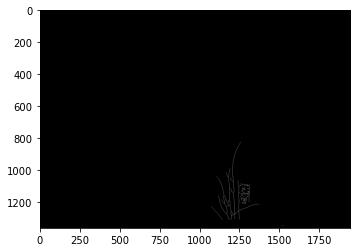

In [41]:
img_names = all_jpg_img(img_path)

lenght_list = []

for name in img_names:
    print(name)
    if name_1_folder(name):
        continue
    if name_2_folder(name):
        continue
    mask = cv2.imread(mask_name(name),cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(int(mask.shape[1]*0.5), int(mask.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
    zero = np.zeros((mask.shape[0],mask.shape[1]))
    if np.array_equal(zero,mask):
        null_mask.append(name)
        continue
    img =  cv2.imread(name)
    img_res = cv2.resize(img,(mask.shape[1], mask.shape[0]), interpolation = cv2.INTER_AREA)
    if mask is None:
        print('mask error')
        continue
    mask_l = final_mask_lenght(mask,img_res)
    mask_2 = final_mask_2(mask,img_res)
    l,pred = lenght(mask_l)
    le = leaf(mask_2,[])
    per = peregib(mask_2,[],le)
    
#     for p in per:
#         cv2.circle(img_res, (p[1],p[0]), 15,(0,0,255), 5)
    
#     for l in le:
#         cv2.circle(img_res, (l[0][1],l[0][0]), 15,(0,0,255), 5)
        
#     for l in pred:
#         cv2.circle(img_res, (l[1],l[0]), 1,(0,0,255), 1)
        
    plt.imshow(mask_2,cmap = 'gray')
        
    w,h,x,y = rectangle(mask)
    c_a = len(Connect_area(mask_2, []))
    l_k = line_kust(mask_2)
    l_k_2 = line_kust_val(mask_2)
    l_k_m = line_kust_max(mask_2) 
    n_per = len(per)
    n_leaf = len(le) - 2*(c_a - 1)
    b_m = bio_mass(mask)
    
    lenght_list.append([sample_name(name),l,n_per,n_leaf, l_k, l_k_2,l_k_m,w,h,b_m,name])

In [42]:
null_mask

['/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/991-9.jpg',
 '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/991-9.jpg']

In [43]:
os.chdir('/home/jupyter-fly_cv/Igor/Plants/')
df =  create_table_with_lenght(lenght_list)
df

,Name,Lenght,Peregib,Leaf_and_Root,line_kust,line_kust_value,max_kust,width_rectangle,height_rectangle,bio_mass,Path
0,453-4-1,1081.193001,8,39,8.0,18.5,40,528,941,92739,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
1,454-26-4,1358.567676,5,39,7.0,15.5,54,720,1146,117758,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
2,454-19,1438.165656,9,44,11.0,19.5,121,1159,582,91148,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
3,449-1-3,1380.912914,12,37,5.0,17.5,59,938,1078,87804,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
4,991-3-4,1222.470129,3,15,3.0,10.0,36,523,1148,50784,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
...,...,...,...,...,...,...,...,...,...,...,...
1134,454-67,628.445743,5,26,4.0,13.0,29,290,459,23451,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
1135,454-50-1,633.575685,3,20,3.0,9.0,20,341,592,23409,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
1136,454-59-3,661.097546,2,9,3.0,8.5,36,455,579,22880,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
1137,454-52-2,553.730014,0,16,5.0,7.5,15,288,483,27706,/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды...
